In [1]:
#imports
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import wradlib as wrl
import xradar as xd

warnings.filterwarnings("ignore")

### Reading the data using Xradr

In [2]:
import os

# Set the WRADLIB_DATA environment variable
os.environ['WRADLIB_DATA'] = 'wradlib_data'

In [3]:
fpath = "scan-sidpol-120km-14_20001_20240814000001_00.h5"
filename = wrl.util.get_wradlib_data_file(fpath)

In [4]:
ds = xr.open_dataset(filename, group="sweep_9", engine="gamic")
display(ds)

<xarray.Dataset> Size: 3MB
Dimensions:            (azimuth: 361, range: 160)
Coordinates:
    elevation          (azimuth) float64 3kB ...
    time               (azimuth) datetime64[ns] 3kB ...
  * range              (range) float32 640B 250.0 750.0 ... 7.925e+04 7.975e+04
    longitude          float64 8B ...
    latitude           float64 8B ...
    altitude           float64 8B ...
  * azimuth            (azimuth) float64 3kB 0.5246 1.56 2.552 ... 358.5 359.5
Data variables: (12/17)
    DBZH               (azimuth, range) float32 231kB ...
    DBZV               (azimuth, range) float32 231kB ...
    sqih               (azimuth, range) float32 231kB ...
    ccorh              (azimuth, range) float32 231kB ...
    DBTH               (azimuth, range) float32 231kB ...
    DBTV               (azimuth, range) float32 231kB ...
    ...                 ...
    RHOHV              (azimuth, range) float32 231kB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...
Attributes:
    source:         gamic
    ant_gain_h:     45.7
    ant_gain_v:     45.8
    noise_power_h:  2.10011
    noise_power_v:  2.96022
    rx_loss_h:      3.59
    rx_loss_v:      4.11

### Using Xradr to read the data for Time Series Sweeps

In [5]:
radar_files = ["scan-sidpol-120km-14_20001_20240814000001_00.h5",
"scan-sidpol-120km-14_20001_20240814000503_00.h5",
"scan-sidpol-120km-14_20001_20240814001001_00.h5"]
files = [wrl.util.get_wradlib_data_file(file) for file in radar_files]

In [7]:
# Read the data using Xradar
def fix_angle(ds):
    """
    Aligns the radar volumes
    """
    ds["time"] = ds.time.load()  # Convert time from dask to numpy

    start_ang = 0  # Set consistent start/end values
    stop_ang = 360

    # Find the median angle resolution
    angle_res = ds.azimuth.diff("azimuth").median()

    # Determine whether the radar is spinning clockwise or counterclockwise
    median_diff = ds.azimuth.diff("time").median()
    ascending = median_diff > 0
    direction = 1 if ascending else -1

    # first find exact duplicates and remove
    ds = xd.util.remove_duplicate_rays(ds)

    # second reindex according to retrieved parameters
    ds = xd.util.reindex_angle(
        ds, start_ang, stop_ang, angle_res, direction, method="nearest"
    )

    ds = ds.expand_dims("volume_time")  # Expand for volumes for concatenation

    ds["volume_time"] = [np.nanmin(ds.time.values)]

    return ds

In [8]:
# Concatenate in xarray ds
ds = xr.open_mfdataset(
    files,
    preprocess=fix_angle,
    #engine="cfradial1",
    engine="gamic",
    #engine="h5netcdf",
    group="sweep_0",
    concat_dim="volume_time",
    combine="nested",
)

In [9]:
# georeference the radar data
ds = ds.xradar.georeference()

## Visualize Data

In [10]:
# Extract the geoaxis information
proj_crs = xd.georeference.get_crs(ds)
cart_crs = ccrs.Projection(proj_crs)

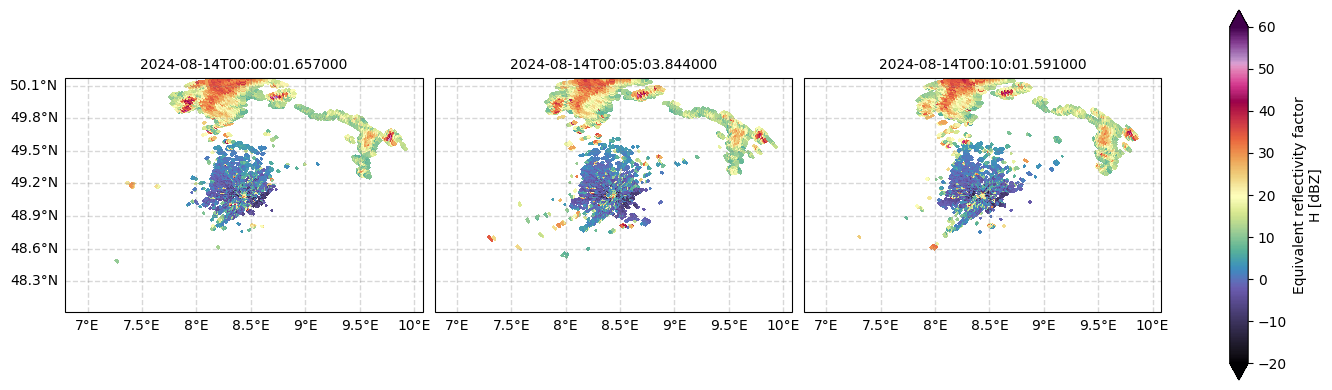

In [11]:
# Create our facets grid
fg = ds.DBZH.plot.pcolormesh(
    x="x",
    y="y",
    vmin=-20,
    vmax=60,
    cmap="ChaseSpectral",
    col="volume_time",
    edgecolors="face",
    figsize=(14, 4),
    transform=cart_crs,
    subplot_kws={"projection": ccrs.PlateCarree()},
)
# Set the title
fg.set_titles("{value}")

# Fix the geo-axes labels
first_axis = True
for ax in fg.axes.flat:
    ax.coastlines()
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="gray",
        alpha=0.3,
        linestyle="--",
    )
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    gl.top_labels = False
    gl.right_labels = False
    if first_axis:
        gl.left_labels = True
    else:
        gl.left_labels = False
    first_axis = False